# To Consider:
+ output files for each step
+ run HDBSCAN for transpose
+ run PalD for task 3
+ output runtime too

# Library

In [2]:
import gzip
import shutil

import pandas as pd
from pyarrow.parquet import read_table
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.base import BaseEstimator, TransformerMixin
from memory_profiler import memory_usage
import matplotlib.pyplot as plt
import seaborn as sns

from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import GridSearchCV

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
from scipy import stats
from sklearn.cluster import HDBSCAN
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor

from sklearn.model_selection import train_test_split
import scipy.sparse

In [3]:
# load sparse matrix for transpose rna
sparse_train = scipy.sparse.load_npz('rna_transpose.npz')

In [4]:
sparse_train.shape

(102710, 27970)

In [5]:
scaler = StandardScaler(with_mean = False)
sparse_train = scaler.fit_transform(sparse_train)

In [9]:
scipy.sparse.save_npz('rna_transpose_scaled.npz', sparse_train)

In [10]:
from sklearn.decomposition import IncrementalPCA

In [12]:
transformer = IncrementalPCA(n_components=2, batch_size=200)
train_transformed = transformer.fit_transform(sparse_train)

In [14]:
row_names = pd.read_csv('col_names.csv', index_col=0)

In [15]:
row_names

,c..PKD_ACACGCGGTATCGGTT.1_1....PKD_ACACGCGGTTTGGCTA.1_1....PKD_ACACGCGTCATGTCTT.1_1...
1,PKD_ACACGCGGTATCGGTT-1_1
2,PKD_ACACGCGGTTTGGCTA-1_1
3,PKD_ACACGCGTCATGTCTT-1_1
4,PKD_ACACTGAAGACCCTTA-1_1
5,PKD_ACACTGAAGCGACAGT-1_1
...,...
102706,Cont_TTTGTTGCAGTTAAAG-1_5
102707,Cont_TTTGTTGCATATTCGG-1_5
102708,Cont_TTTGTTGGTACGATTC-1_5
102709,Cont_TTTGTTGGTGCGTTTA-1_5


In [16]:
pca_df = pd.DataFrame(train_transformed, columns=["PC1", "PC2"], index=row_names)

In [18]:
pca_df.to_csv('rna_transpose_pca')

In [4]:
pca_df = pd.read_csv('rna_transpose_pca', index_col=0)

In [6]:
pca_df.head()

,PC1,PC2
"('PKD_ACACGCGGTATCGGTT-1_1',)",-20.509642,-3.325422
"('PKD_ACACGCGGTTTGGCTA-1_1',)",-14.033928,6.092596
"('PKD_ACACGCGTCATGTCTT-1_1',)",-15.427393,-7.239779
"('PKD_ACACTGAAGACCCTTA-1_1',)",-24.985925,0.150465
"('PKD_ACACTGAAGCGACAGT-1_1',)",-3.921872,7.703875


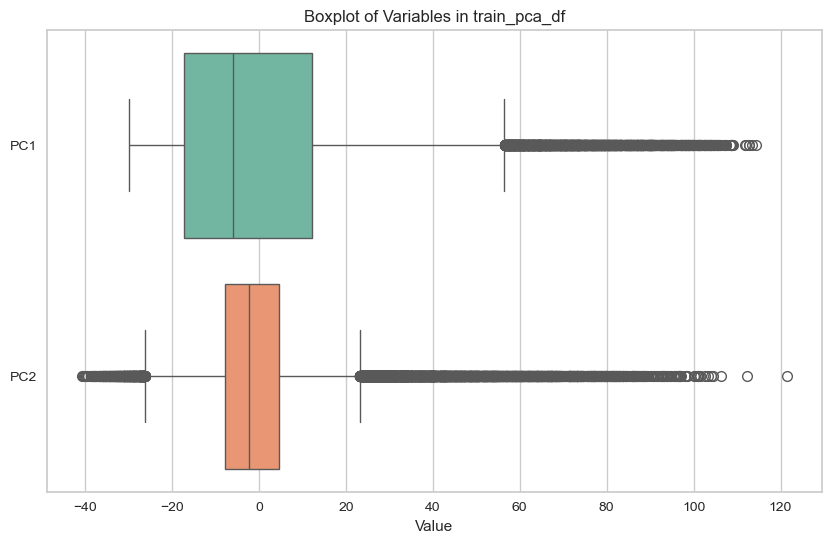

In [7]:

# Set up the figure
plt.figure(figsize=(10, 6))

# Create a boxplot for both variables in train_pca_df
sns.boxplot(data=pca_df, orient="h", palette="Set2")
plt.title('Boxplot of Variables in train_pca_df')
plt.xlabel('Value')

# Show the plot
plt.show()

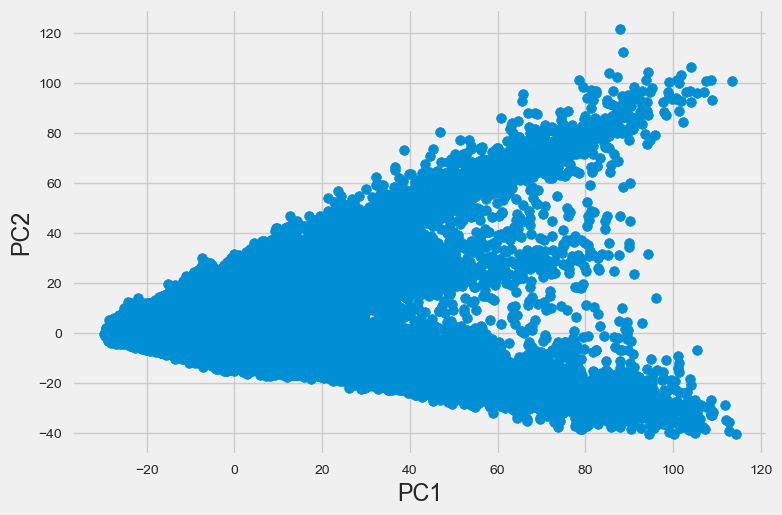

In [9]:
plt.style.use("fivethirtyeight")
plt.scatter(pca_df.loc[:,'PC1'],  pca_df.loc[:,'PC2'])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show();

# Cluster Analysis

## K-Means

In [10]:
def optimize_and_compare_kmeans(data, kmeans_params, alpha=0.05):
    # Perform Grid Search
    grid = GridSearchCV(KMeans(), kmeans_params, cv=3, refit=True)
    grid.fit(data)
    grid_search_estimator = grid.best_estimator_

    # Calculate silhouette scores
    default_kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(data)
    default_silhouette_score = silhouette_score(data, default_kmeans.labels_)
    grid_search_silhouette_score = silhouette_score(data, grid_search_estimator.labels_)

    # Perform a two-sample t-test only if Grid Search performs better
    if grid_search_silhouette_score > default_silhouette_score:
        t_stat, p_value = stats.ttest_ind(default_kmeans.labels_, grid_search_estimator.labels_)

        # Set the default choice to "Grid Search Estimator"
        choice = "KMeans Estimator"

        # Output informative print statements
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

        if p_value < alpha:
            choice = "Grid Search Estimator"
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better using a threshold of alpha = .05 .")
            return choice, grid_search_estimator
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement using a threshold of alpha = .05.")
            return choice, default_kmeans
    else:
        choice = "Default Parameter"
        print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)
        print("Default KMeans Silhouette Score:", default_silhouette_score)
        print("Default Parameter has a higher Silhouette Score.")
        print("Using Default Parameter as it performs better based on Silhouette Score.")
        return choice, default_kmeans

     # Return both choice and the chosen KMeans clusterer


# Usage example with parameters
kmeans_params = {
    'n_clusters': list(range(1, 10)),
    'init': ['random', 'k-means++'],
    'n_init': [1, 5, 10],
    'max_iter': [300],
    'random_state': [0]
}
choice, k_means_estimator = optimize_and_compare_kmeans(pca_df, kmeans_params)

Grid Search Estimator Silhouette Score: 0.45109296721198466
Default KMeans Silhouette Score: 0.5389544375522474
Default Parameter has a higher Silhouette Score.
Using Default Parameter as it performs better based on Silhouette Score.


In [11]:
k_means_estimator

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [12]:
def find_outliers_in_clusters(data, clusterer, n_neighbors=20, contamination=0.1):
    # Fit the Local Outlier Factor (LOF) model on the data
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(data)

    # Create a DataFrame to store cluster labels and outlier labels
    cluster_outliers = pd.DataFrame({'Cluster': clusterer.labels_, 'Outlier': outliers})

    # Print the number of data points and percentage of outliers in each cluster
    cluster_info = cluster_outliers.groupby('Cluster').agg(DataPoints=('Cluster', 'count'),
                                                          PercentageOutliers=('Outlier', lambda x: (x == -1).mean() * 100))
    print("Cluster Information:")
    print(cluster_info)

    return cluster_outliers

# Example usage:
# Assuming you already have a KMeans clusterer 'chosen_kmeans' from the previous code
outliers_in_clusters = find_outliers_in_clusters(pca_df, k_means_estimator)
outliers_in_clusters



Cluster Information:
         DataPoints  PercentageOutliers
Cluster                                
0             29973           14.206119
1             72737            8.266769


,Cluster,Outlier
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
102705,1,1
102706,1,1
102707,1,-1
102708,1,1


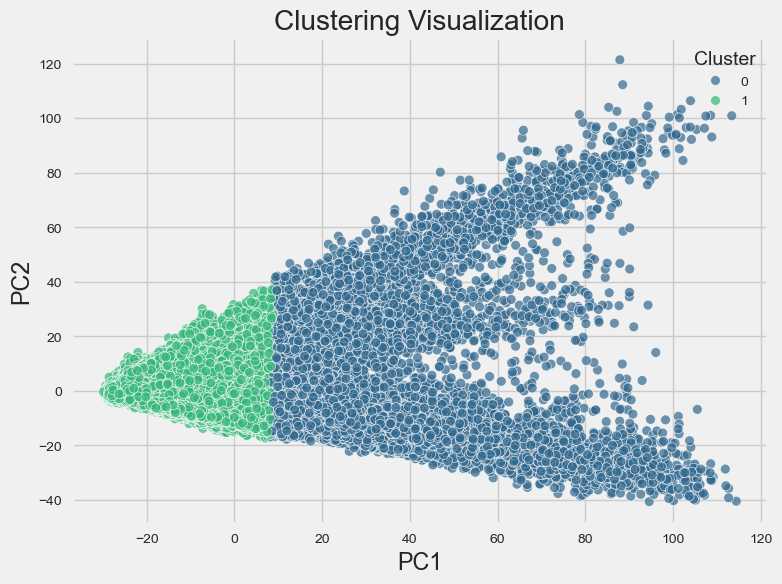

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot to visualize the clustering
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=k_means_estimator.labels_, palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

In [14]:
pca_df_kmean = pca_df
pca_df_kmean["cluster"] = k_means_estimator.labels_

In [16]:
pca_df_kmean.to_csv('rna_transpose_kmean')

## HDBSCAN

In [5]:
def silhouette_scorer(estimator, X):
    labels = estimator.fit_predict(X)
    if len(set(labels)) == 1:
        return 0  # Silhouette score is undefined for a single cluster
    return silhouette_score(X, labels)

def optimize_and_compare_hdbscan(data, hdbscan_params, alpha=0.05):
    # Perform Grid Search
    grid_search = GridSearchCV(
        estimator=HDBSCAN(min_cluster_size=20),
        param_grid=hdbscan_params,
        scoring=silhouette_scorer,
        cv=5,
        n_jobs=-1,
    )
    grid_search.fit(data)
    grid_search_estimator = grid_search.best_estimator_

    # Calculate silhouette scores for the default and grid search estimators
    default_hdbscan = HDBSCAN(min_cluster_size=20).fit(data)
    default_labels = default_hdbscan.labels_
    default_silhouette_score = silhouette_score(data, default_labels)

    grid_search_labels = grid_search_estimator.fit_predict(data)
    grid_search_silhouette_score = silhouette_score(data, grid_search_labels)

    # Check if the grid search estimator has a higher silhouette score
    if grid_search_silhouette_score > default_silhouette_score:
        # Perform a two-sample t-test
        t_stat, p_value = stats.ttest_ind(default_labels, grid_search_labels)

        # Check if the p-value is less than the significance level
        if p_value < alpha:
            choice = "Grid Search Estimator"
        else:
            choice = "Default Parameter"
    else:
        choice = "Default Parameter"

    # Output informative print statements
    print("Default HDBSCAN Silhouette Score:", default_silhouette_score)
    print("Grid Search Estimator Silhouette Score:", grid_search_silhouette_score)

    if grid_search_silhouette_score > default_silhouette_score:
        if p_value < alpha:
            print("The difference between the two groups is statistically significant.")
            print(f"Using {choice} as it performs significantly better.")
        else:
            print("The difference between the two groups is not statistically significant.")
            print(f"Using {choice} as there is no significant improvement.")
    else:
        print("Default Parameter has a higher silhouette score. No t-test performed.")

    return choice

# Define the parameter grid for HDBSCAN
hdbscan_params = {
    'min_samples': [10, 30, 50, 60, 100],
    'min_cluster_size': [100, 200],
    'cluster_selection_method': ['eom', 'leaf'],
    'metric': ['euclidean', 'manhattan']
}

# Usage example with parameters
result = optimize_and_compare_hdbscan(pca_df, hdbscan_params)

In [ ]:
# Set up the figure
plt.figure(figsize=(8, 6))

# Create a scatter plot to visualize the clustering
sns.scatterplot(x='PC1', y='PC2', data=pca_df, hue=result.labels_, palette='viridis', s=50, alpha=0.7)

# Add labels and title
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clustering Visualization')

# Show the plot
plt.grid(True)
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Cluster Profile

In [66]:
metadata = pd.read_csv('GSE185948_metadata_RNA.csv')
metadata.head()

,name,barcode,patient,gender,disease,celltype,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2
0,PKD_ACACGCGGTATCGGTT-1_1,ACACGCGGTATCGGTT-1,PKD1,female,PKD,TAL1,1234.684629,1250,-7.416020,-6.008874
1,PKD_ACACGCGGTTTGGCTA-1_1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
2,PKD_ACACGCGTCATGTCTT-1_1,ACACGCGTCATGTCTT-1,PKD1,female,PKD,CNT_PC,1812.700523,1419,-2.254505,8.526364
3,PKD_ACACTGAAGACCCTTA-1_1,ACACTGAAGACCCTTA-1,PKD1,female,PKD,FIB,978.772591,1089,9.949437,2.086737
4,PKD_ACACTGAAGCGACAGT-1_1,ACACTGAAGCGACAGT-1,PKD1,female,PKD,PT1,2361.558871,2013,7.886921,-8.587954


In [67]:
cluster = pd.read_csv('rna_transpose_kmean', index_col=0)
cluster.head()

,PC1,PC2,cluster
"('PKD_ACACGCGGTATCGGTT-1_1',)",-20.509642,-3.325422,1
"('PKD_ACACGCGGTTTGGCTA-1_1',)",-14.033928,6.092596,1
"('PKD_ACACGCGTCATGTCTT-1_1',)",-15.427393,-7.239779,1
"('PKD_ACACTGAAGACCCTTA-1_1',)",-24.985925,0.150465,1
"('PKD_ACACTGAAGCGACAGT-1_1',)",-3.921872,7.703875,1


In [46]:
col_name = pd.read_csv('col_names.csv', index_col=0)
col_name = col_name.rename(columns={col_name.columns[0]: "name" })
col_name.head()

,name
1,PKD_ACACGCGGTATCGGTT-1_1
2,PKD_ACACGCGGTTTGGCTA-1_1
3,PKD_ACACGCGTCATGTCTT-1_1
4,PKD_ACACTGAAGACCCTTA-1_1
5,PKD_ACACTGAAGCGACAGT-1_1


In [75]:
cluster = cluster.rename(dict(zip(cluster.index, col_name['name'])))

In [77]:
cluster = cluster.reset_index()
cluster.head()

,index,PC1,PC2,cluster
0,PKD_ACACGCGGTATCGGTT-1_1,-20.509642,-3.325422,1
1,PKD_ACACGCGGTTTGGCTA-1_1,-14.033928,6.092596,1
2,PKD_ACACGCGTCATGTCTT-1_1,-15.427393,-7.239779,1
3,PKD_ACACTGAAGACCCTTA-1_1,-24.985925,0.150465,1
4,PKD_ACACTGAAGCGACAGT-1_1,-3.921872,7.703875,1


In [90]:
meta_df = pd.merge(cluster, metadata, left_on='index', right_on='name', how='left').drop('name', axis=1)
meta_df.head()

,index,PC1,PC2,cluster,barcode,patient,gender,disease,celltype,nCount_RNA,nFeature_RNA,UMAP_1,UMAP_2
0,PKD_ACACGCGGTATCGGTT-1_1,-20.509642,-3.325422,1,ACACGCGGTATCGGTT-1,PKD1,female,PKD,TAL1,1234.684629,1250,-7.416020,-6.008874
1,PKD_ACACGCGGTTTGGCTA-1_1,-14.033928,6.092596,1,ACACGCGGTTTGGCTA-1,PKD1,female,PKD,PT2,1865.542588,1650,2.499409,-6.587287
2,PKD_ACACGCGTCATGTCTT-1_1,-15.427393,-7.239779,1,ACACGCGTCATGTCTT-1,PKD1,female,PKD,CNT_PC,1812.700523,1419,-2.254505,8.526364
3,PKD_ACACTGAAGACCCTTA-1_1,-24.985925,0.150465,1,ACACTGAAGACCCTTA-1,PKD1,female,PKD,FIB,978.772591,1089,9.949437,2.086737
4,PKD_ACACTGAAGCGACAGT-1_1,-3.921872,7.703875,1,ACACTGAAGCGACAGT-1,PKD1,female,PKD,PT1,2361.558871,2013,7.886921,-8.587954


## start profiling

In [113]:
meta_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,102710,102710,PKD_ACACGCGGTATCGGTT-1_1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PC1,102710.0,NaN,NaN,NaN,-0.0,22.517106,-29.818219,-17.342994,-6.01231,12.187597,114.390407
PC2,102710.0,NaN,NaN,NaN,0.0,13.214772,-40.653122,-7.705227,-2.198756,4.648326,121.430886
cluster,102710.0,NaN,NaN,NaN,0.708178,0.454603,0.0,0.0,1.0,1.0,1.0
barcode,102710,101388,TCACATTAGGTCATCT-1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
patient,102710,13,PKD2,10912,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,102710,2,female,51792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
disease,102710,2,PKD,62073,NaN,NaN,NaN,NaN,NaN,NaN,NaN
celltype,102710,15,TAL1,24283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nCount_RNA,102710.0,NaN,NaN,NaN,2817.206425,1664.05292,604.6487,1545.956238,2377.02539,3687.133258,10892.05313


In [132]:
# Overall level summary
df_overall_cont = meta_df.describe().T
df_profile_mean = meta_df.describe().T[['mean']]
df_profile_mean

,mean
PC1,-3.541991e-16
PC2,2.302294e-16
cluster,7.081784e-01
nCount_RNA,2.817206e+03
nFeature_RNA,1.932712e+03
UMAP_1,-2.511785e-12
UMAP_2,1.703857e-12


In [133]:
df_profile_freq = meta_df.describe(include=['object']).T
df_profile_freq[['freq']]

,freq
index,1
barcode,3
patient,10912
gender,51792
disease,62073
celltype,24283


In [150]:
df_cluster_cont = meta_df.groupby('cluster').describe().T.reset_index()
df_cluster_cont = df_cluster_cont.rename(columns={'level_0':'column','level_1':'metric'})
df_cluster_cont.loc[df_cluster_cont['metric'] == 'mean']

cluster,column,metric,0,1
1,PC1,mean,28.856274,-11.890910
9,PC2,mean,-0.447085,0.184232
17,nCount_RNA,mean,4913.749924,1953.276125
25,nFeature_RNA,mean,2820.953124,1566.691230
33,UMAP_1,mean,-2.483431,1.023357
41,UMAP_2,mean,-1.077497,0.444008


In [159]:
df_cluster_cat = meta_df.groupby('cluster').describe(include = 'object').T.reset_index()
df_cluster_cat = df_cluster_cat.rename(columns={'level_0':'column','level_1':'metric'})
df_cluster_cat.loc[df_cluster_cat['metric'] == 'freq'].set_index('column')

cluster,metric,0,1
column,,,
index,freq,1,1
barcode,freq,2,3
patient,freq,7675,9303
gender,freq,22919,44738
disease,freq,19020,51120
celltype,freq,11008,13775


In [ ]:

# Overall level summary
df_profile_overall = df_features.describe().T

# using mean; use appropriate summarization (median, count, etc.) for each feature
df_profile_overall['Overall Dataset'] = df_profile_overall[['mean']]
df_profile_overall = df_profile_overall[['Overall Dataset']]

# Cluster ID level summary
df_cluster_summary = df_features.groupby('cluster_ids').describe().T.reset_index()
df_cluster_summary = df_cluster_summary.rename(columns={'level_0':'column','level_1':'metric'})

# using mean; use appropriate summarization (median, count, etc.) for each feature
df_cluster_summary = df_cluster_summary[df_cluster_summary['metric] == "mean"]
df_cluster_summary = df_cluster_summary.set_index('column')

# join into single summary dataset
df_profile = df_cluster_summary.join(df_profile_overall) # joins on Index